In [ ]:
!pip install pyyaml==5.4.1
!pip install darts
!pip install matplotlib==3.1.3

In [7]:
import time
import joblib
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics.tsaplots import plot_acf
from datetime import datetime as dt
from datetime import timedelta, timezone
from scipy.signal import lombscargle, periodogram
import darts
from darts import TimeSeries
from darts.models import KalmanFilter, RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.utils import timeseries_generation as tg
from darts.metrics import mape
import torch
import statistics
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [9]:
# constants 
input_chunk_length = 64

patient_ids = [183, 184,  14, 220, 233,  62,  17, 186,  52, 216, 115,  37, 244,
       167, 265,  81, 113, 248,  76,  21,  79, 132, 215, 223, 110,  19,
       260, 289,  54,  64, 232, 172,  45, 203, 119,  31,  24, 156, 276,
       162, 240, 239,  32, 236,  73,  26, 205,  48, 267,   2, 256, 141,
         8,  22, 204, 163,  42, 226, 251, 198, 165,  60, 264, 241, 138,
        67,  90, 206,  38, 266, 281,  10,  41, 185,  35, 140, 283, 118,
        80, 123, 217,  39, 160, 112,  50, 292, 164, 246,  18, 128, 103,
       210,   9,  71, 169,  65, 166,  74,  96, 134, 271,  55, 228, 234,
       155, 139,  95,   7,  11,  61, 250, 168, 108, 252, 106,  68, 213,
       127,  36, 176, 273, 130, 136, 152,  53, 193, 243, 253, 148, 135,
       274, 287, 231, 105, 201,   3, 200, 245,  91,  98, 101, 137,  70,
       219, 121, 143,  23, 109, 263,  46, 229,  93, 188,  72, 190, 211,
       218,  77, 181, 288, 278,  87, 173,  47,  33, 277, 224,  43, 257,
        69, 175,  58, 124,  78, 116, 146,  49,  30,  16,  86,   5, 158,
       171, 179, 258, 284, 170, 147, 249,  97, 131, 272, 285, 174, 222,
       102, 221,  15,  89,  57,  82,  29, 214, 149, 227,  20, 280, 247,
       269, 157,  40, 293, 145, 197,  27, 187, 254, 235, 209, 129, 177,
       291, 189, 290, 275, 111]

In [8]:
# functions
def downcast_to_float_32(df):
    df['GlucoseValue'] = df['GlucoseValue'].astype(np.float32)
    df['TotalDeviceMinutes'] = df['TotalDeviceMinutes'].astype(np.float32)
    df['TotalInternalHours_Diff'] = df['TotalInternalHours_Diff'].astype(np.float32)
    return df

def get_all_resampled_patient_timeseries(patient_dfs, value_column = "GlucoseValue"):
  all_patient_timeseries = []
  for df in patient_dfs: 
    individual_patient_timeseries = TimeSeries.from_dataframe(df, value_cols = [value_column]) 
    all_patient_timeseries.append(individual_patient_timeseries)
  return all_patient_timeseries

def get_resampled_patient_dfs(): 
  resampled_patient_dfs = []
  for patient_id in patient_ids:
    # patient_ids less than ten lead with 0, eg: 01
    patient_id_string = f'0{patient_id}' if patient_id < 10 else str(patient_id)
    df = pd.read_hdf(f'/content/drive/MyDrive/Colab Notebooks/glucose_prediction/data/resampled/patient_df_{patient_id_string}.h5')  
    df = downcast_to_float_32(df)
    resampled_patient_dfs.append(df)
  return resampled_patient_dfs

def get_filtered_patient_dfs(): 
  filtered_patient_dfs = []
  for patient_id in patient_ids:
    # patient_ids less than ten lead with 0, eg: 01
    patient_id_string = f'0{patient_id}' if patient_id < 10 else str(patient_id)
    df = pd.read_hdf(f'/content/drive/MyDrive/Colab Notebooks/glucose_prediction/data/filtered/patient_df_{patient_id_string}.h5')  
    df = downcast_to_float_32(df)
    filtered_patient_dfs.append(df)
  return filtered_patient_dfs

def plot_forecast(series_train, series_forecast, mape, ax):
  ax.plot(series_train, label="actual")
  ax.plot(series_forecast, label="forecast")
  plt.legend(["actual", "forecast"])
  print("MAPE = {:.2f}%".format(mape))

def get_rolling_30min_prediction(test_timeseries, model): 
  last_predictable_timestep = len(resampled_patient_timeseries_train[0]) - input_chunk_length - 1
  prediction_range = range(input_chunk_length+1, last_predictable_timestep, 1)
  predictions = []
  for prediction_window_end_index in prediction_range: 
    print(f"start index = {prediction_window_end_index-input_chunk_length}")
    print(f"stop index = {prediction_window_end_index}")
    prediction_timesereies_window = test_timeseries[prediction_window_end_index-input_chunk_length:prediction_window_end_index]
    prediction = model.predict(n=1, series=prediction_timesereies_window, verbose=False, n_jobs=8)
    predictions.append(prediction)
  return predictions

In [10]:
# load resampled data 
resampled_patient_dfs = get_resampled_patient_dfs()
# use 50/50 for test/train for now
train_cutoff_index = round(len(resampled_patient_dfs)/2)

# dfs
resampled_patient_dfs_train = resampled_patient_dfs[:train_cutoff_index]
resampled_patient_dfs_test = resampled_patient_dfs[train_cutoff_index:]

# time-series
resampled_patient_timeseries_train = get_all_resampled_patient_timeseries(resampled_patient_dfs_train, "GlucoseValue")
resampled_patient_timeseries_test = get_all_resampled_patient_timeseries(resampled_patient_dfs_test, "GlucoseValue")

In [44]:
%time
tcn_model = TCNModel(input_chunk_length=256, output_chunk_length=1, dilation_base = 2, dropout=0.3, n_epochs=60, torch_device_str="cuda", batch_size=256)
resampled_patient_timeseries_train = [ individual_ts for individual_ts in resampled_patient_timeseries_train if len(individual_ts) > 256]
tcn_model.fit(resampled_patient_timeseries_train, max_samples_per_ts=500)
tcn_model.save_model("/content/drive/MyDrive/Colab Notebooks/glucose_prediction/models/tcn/TCN_60_epochs.pth.tar.pth.tar")


[2022-05-05 17:50:39,708] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: `torch_device_str` is deprecated and will be removed in a coming Darts version. For full support of all torch devices, use PyTorch-Lightnings trainer flags and pass them inside `pl_trainer_kwargs`. Flags of interest are {`accelerator`, `gpus`, `auto_select_gpus`, `devices`}. For more information, visit https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-flags
[2022-05-05 17:50:39,708] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: `torch_device_str` is deprecated and will be removed in a coming Darts version. For full support of all torch devices, use PyTorch-Lightnings trainer flags and pass them inside `pl_trainer_kwargs`. Flags of interest are {`accelerator`, `gpus`, `auto_select_gpus`, `devices`}. For more information, visit https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-flags
2022-05-

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


Training: 0it [00:00, ?it/s]

After some testing, I noticed that the loss for 60 epochs is about the same as for ~400 or ~500. Thus, favor shorter training time.

In [15]:
model_path = "/content/drive/MyDrive/Colab Notebooks/glucose_prediction/models/tcn/TCN_100_epochs.pth.tar.pth.tar"

In [13]:
tcn_model.save_model(model_path)

In [45]:
# Model Evaluation: Train 
# GET MAPE and Historical Predictions
resampled_patient_timeseries_train = [ individual_ts for individual_ts in resampled_patient_timeseries_train if len(individual_ts) > 256]
tcn_model = TCNModel.load_model(model_path)

last_point_historical_predictions_train = []
train_mapes = []
for i, individual_resampled_patient_timeseries_train in enumerate(resampled_patient_timeseries_train):
  series_length = len(individual_resampled_patient_timeseries_train)
  if(series_length <= 256):
    print(f"ignored series with length  was {len(individual_resampled_patient_timeseries_train)}")
    continue

  if(i>= 20):
    break

  stride = round(len(individual_resampled_patient_timeseries_train)/10) # stride width = 1/10th the timeseries each time. 
  last_point_mape = tcn_model.backtest(individual_resampled_patient_timeseries_train, start=0.1, forecast_horizon=1, stride=stride, metric=mape, last_points_only=True, retrain=False, verbose=False)
  train_mapes.append(last_point_mape)

  # only get historical forecasts for 5 time_series for performance
  if(i< 5):
    last_point_predictions = tcn_model.historical_forecasts(individual_resampled_patient_timeseries_train, start=0.2, forecast_horizon=1, stride=1, last_points_only=True, retrain=False, verbose=False)
    last_point_historical_predictions_train.append(last_point_predictions)


Predicting: 0it [00:00, ?it/s]

In [ ]:
# Model Evaluation: Test 
# GET MAPE and Historical Predictions
individual_resampled_patient_timeseries_test = [ individual_ts for individual_ts in resampled_patient_timeseries_test if len(individual_ts) > 256]
tcn_model = TCNModel.load_model(model_path)
last_point_historical_predictions_test = []
test_mapes = []
for i, individual_resampled_patient_timeseries_test in enumerate(resampled_patient_timeseries_test):
  if(i>= 20):
    break

  stride = round(len(individual_resampled_patient_timeseries_test)/10) # stride width = 1/10th the timeseries each time. 
  last_point_mape = tcn_model.backtest(individual_resampled_patient_timeseries_test, start=0.5, forecast_horizon=1, stride=stride, metric=mape, last_points_only=True, retrain=False, verbose=False)
  test_mapes.append(last_point_mape)

  # only get historical forecasts for 5 time_series for performance
  if(i< 5):
    last_point_predictions = tcn_model.historical_forecasts(individual_resampled_patient_timeseries_test, start=0.5, forecast_horizon=1, stride=1, last_points_only=True, retrain=False, verbose=False)
    last_point_historical_predictions_test.append(last_point_predictions)

In [47]:
print(f"Mean Train MAPE for first 20 train patients was: {statistics.mean(train_mapes)}%")
print(f"Mean Test MAPE for first 20 test patients was: {statistics.mean(test_mapes)}%")

Mean Train MAPE for first 20 train patients was: 14.815334659069777%
Mean Test MAPE for first 20 test patients was: 14.324828628450632%


Note: There is NOT overfitting, BUT the Test Absolute Percentage Error Percentage Error is not very good. TCN appears to act similar to a kalman filter or even a low pass filter (possibly a FFT predictor). 

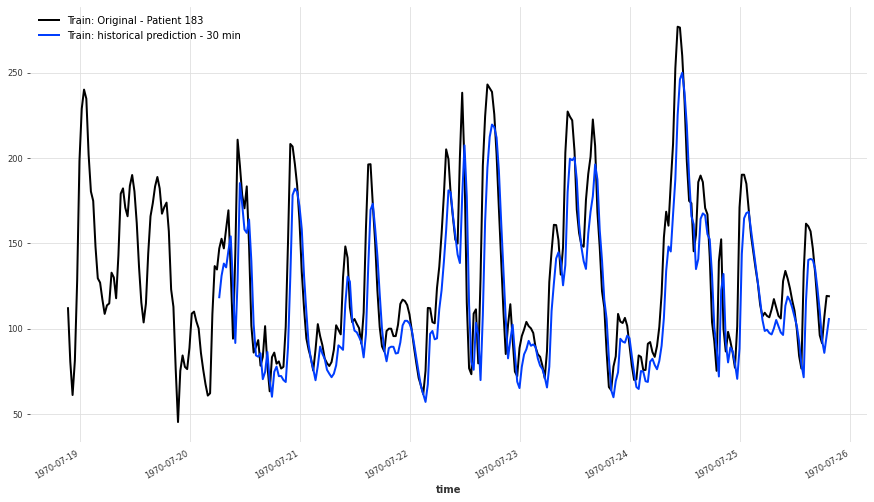

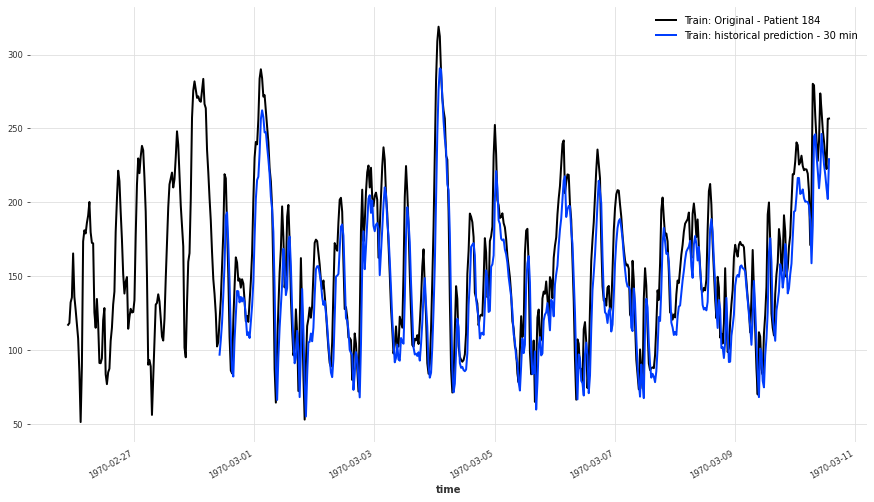

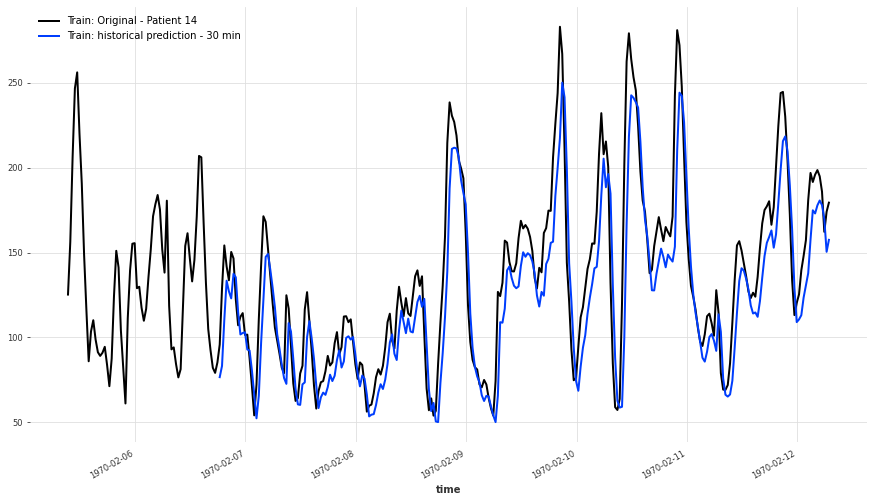

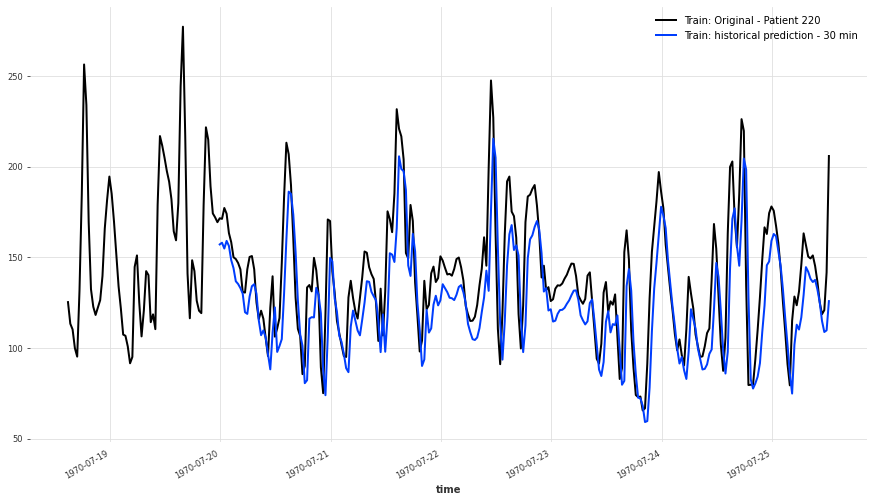

In [52]:
# Train Historical Prediction plot
index = 0 
for patient_id_index in range(0, 4):
  plt.figure(figsize=(15,8))
  resampled_patient_timeseries_train[patient_id_index].plot(label=f"Train: Original - Patient {patient_ids[patient_id_index]}")
  last_point_historical_predictions_train[patient_id_index].plot(label="Train: historical prediction - 30 min")

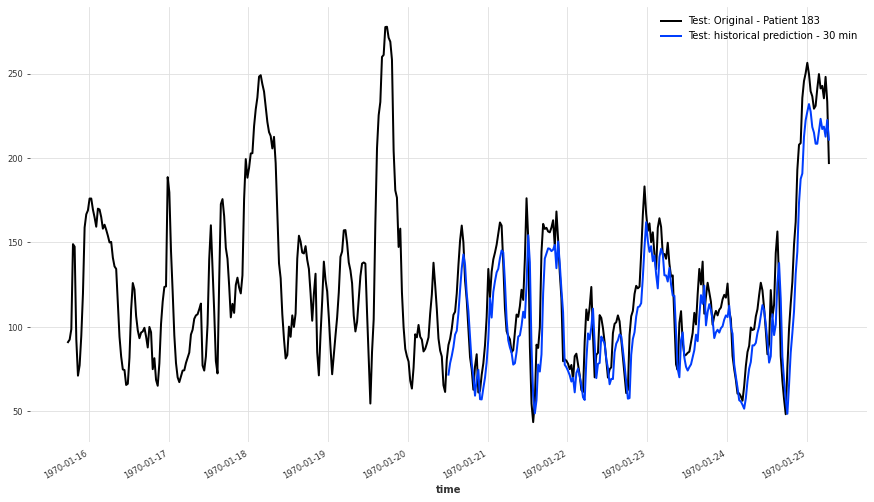

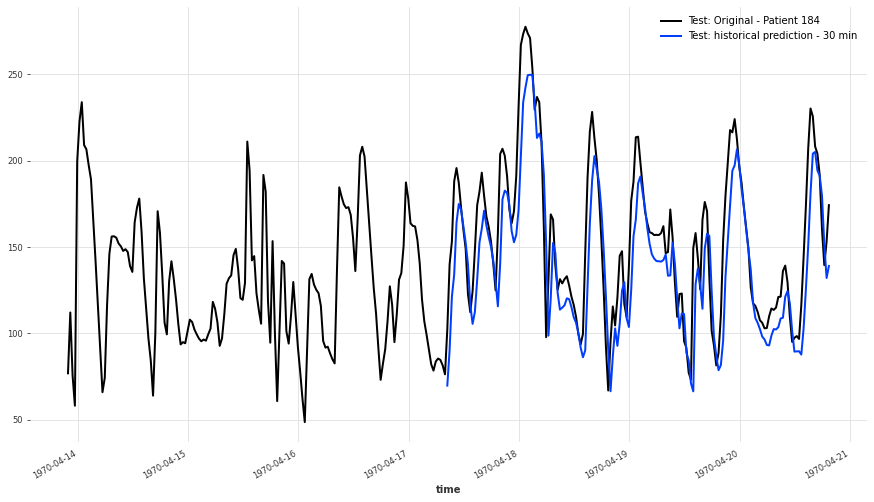

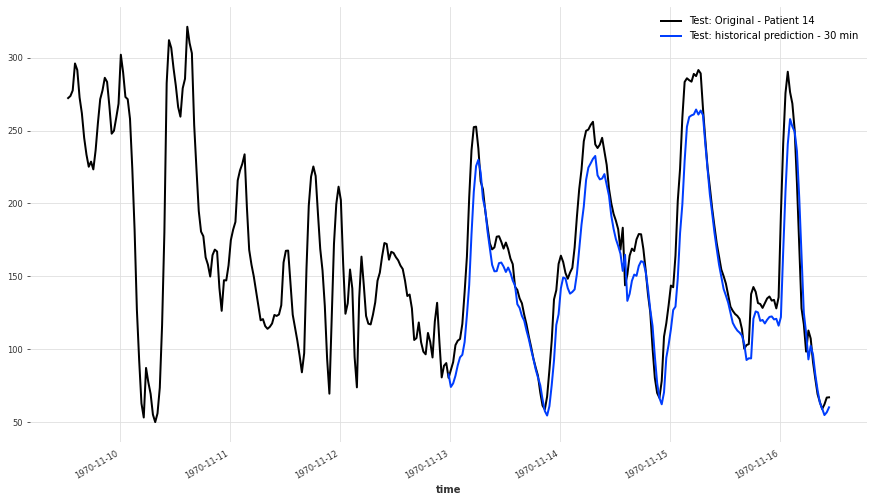

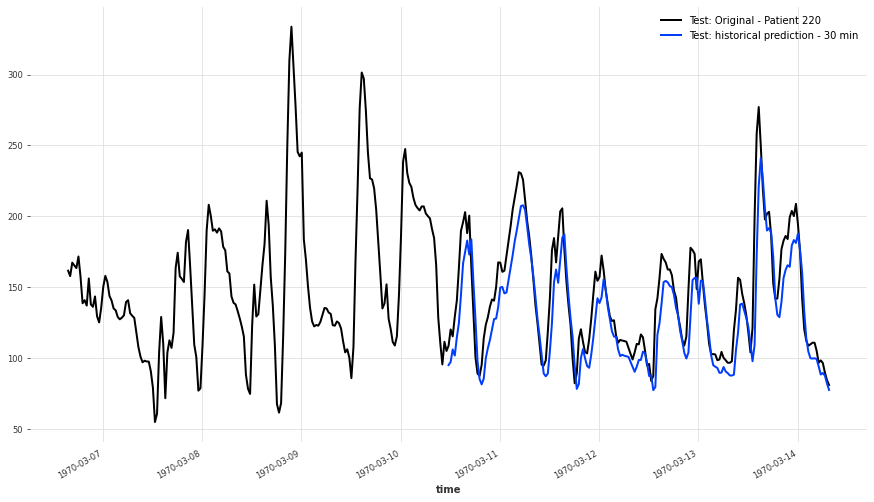

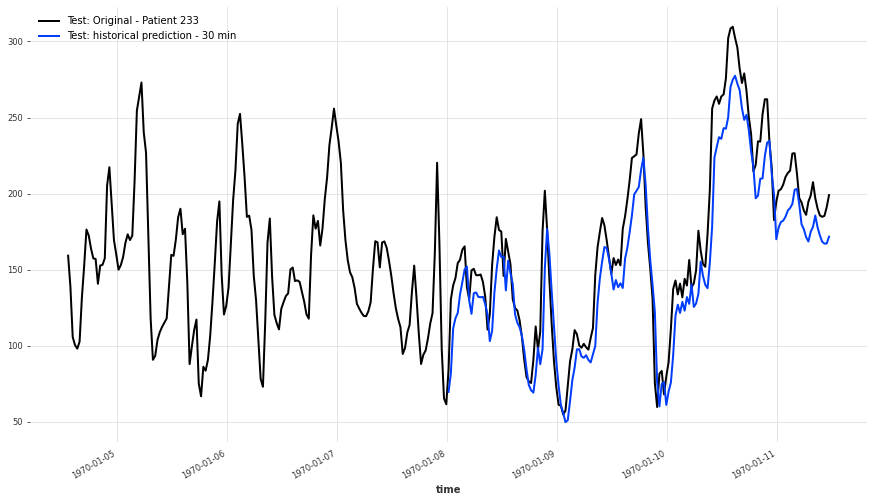

In [53]:
# Test Historical Prediction plot
index = 0 
for patient_id_index in range(0, 5):
  plt.figure(figsize=(15,8))
  resampled_patient_timeseries_test[patient_id_index].plot(label=f"Test: Original - Patient {patient_ids[patient_id_index]}")
  last_point_historical_predictions_test[patient_id_index].plot(label="Test: historical prediction - 30 min")

Due to the low pass "daily mean fitting" behavior, and high test MAPE, next steps would be increase the depth of the TCN by increasing the kernel size. Other parameters could be investigated with a grid search too.  

Next step: grid search best number of epochs, number of layers, chunk size, and more with a validation set (val_series in a gridsearch()) to allow for better validation so we can reduce overfitting by picking the best model hyperparameters in terms of lowest validation MAPE. Basically, pick the hyperparameters which reduce overfitting

see: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html

In [ ]:
#NBEATS - Parameter Grid Search WIP
# This seems to run very slow OR run out of memory in Google Collab
# TODO: figure out what is causing this to take so long. 
%time
parameters = {
    "n_epochs": [200,400,600],
    "input_chunk_length": [100, 200, 300],
    "output_chunk_length": [1],
    "dropout" : [0.1, 0.2, 0.3, 0.4]
    # torch_device_str="cuda" 
    # "num_layers": [200]
}

# last 5000 elements 
nbeats_gridsearch_train_X = resampled_patient_timeseries_train[-50].tail(5000)
nbeats_gridsearch = NBEATSModel.gridsearch(parameters = parameters, 
                        series=nbeats_gridsearch_train_X,
                        forecast_horizon=1,
                        last_points_only=True,
                        metric=mape,
                        # n_jobs=-1,
                        verbose=True
                        )